<a href="https://colab.research.google.com/github/ritusingla/deep-image-prior/blob/master/final_flash_no_flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!git clone https://github.com/ritusingla/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 535 (delta 70), reused 149 (delta 41), pack-reused 308
Receiving objects: 100% (535/535), 247.95 MiB | 20.34 MiB/s, done.
Resolving deltas: 100% (233/233), done.
Checking out files: 100% (251/251), done.
mv: cannot move 'deep-image-prior/demo' to './demo': Directory not empty
mv: cannot move 'deep-image-prior/feature_learning_tests' to './feature_learning_tests': Directory not empty
mv: cannot move 'deep-image-prior/models' to './models': Directory not empty
mv: cannot move 'deep-image-prior/resources' to './resources': Directory not empty
mv: cannot move 'deep-image-prior/train' to './train': Directory not empty
mv: cannot move 'deep-image-prior/train_alexnet' to './train_alexnet': Directory not empty


# Import libs

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models import *

import torch
import torch.optim

from utils.denoising_utils import *
from utils.sr_utils import load_LR_HR_imgs_sr
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True

# Load image

HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)


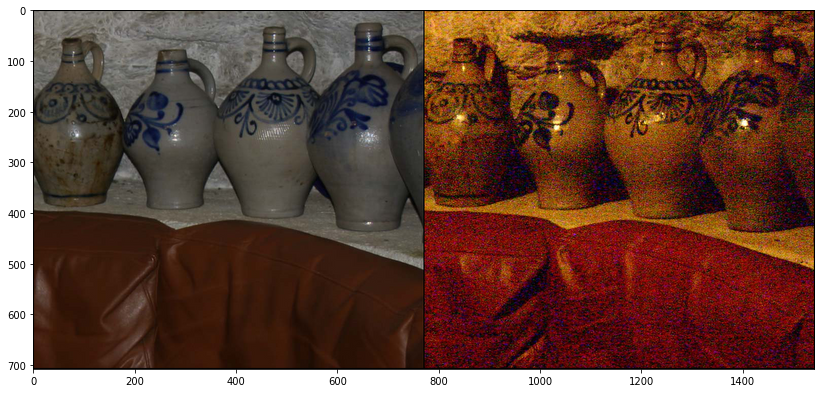

In [46]:
imgs = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')
img_flash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_flash_np = pil_to_np(img_flash)

img_noflash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_01_noflash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_noflash_np = pil_to_np(img_noflash)

g = plot_image_grid([img_flash_np, img_noflash_np],3,12)

# Setup

In [0]:
pad = 'reflection'
OPT_OVER = 'net'

num_iter = 601
LR = 0.1 
OPTIMIZER = 'adam'
reg_noise_std = 0.0
show_every = 50
figsize = 6

# We will use flash image as input
input_depth = 3
net_input =np_to_torch(img_flash_np).type(dtype)

In [0]:
net = skip(input_depth, 3, num_channels_down = [128, 128, 128, 128, 128], 
                        num_channels_up   = [128, 128, 128, 128, 128],
                        num_channels_skip = [4, 4, 4, 4, 4], 
                        upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
                        need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

mse = torch.nn.MSELoss().type(dtype)

img_flash_var = np_to_torch(img_flash_np).type(dtype)
img_noflash_var = np_to_torch(img_noflash_np).type(dtype)

# Optimize

Starting optimization with ADAM


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration 00000    Loss 0.111636

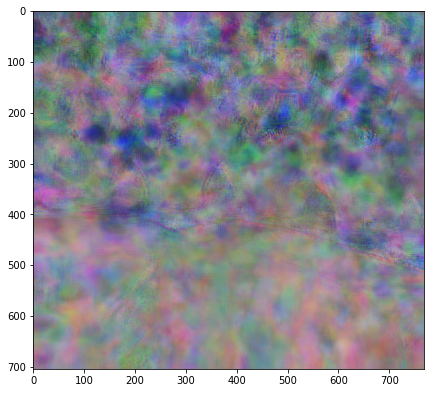

Iteration 00050    Loss 0.016621

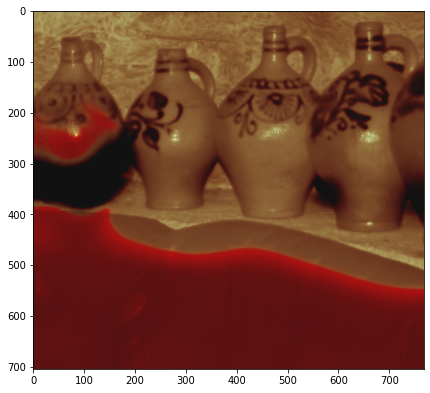

Iteration 00100    Loss 0.011060

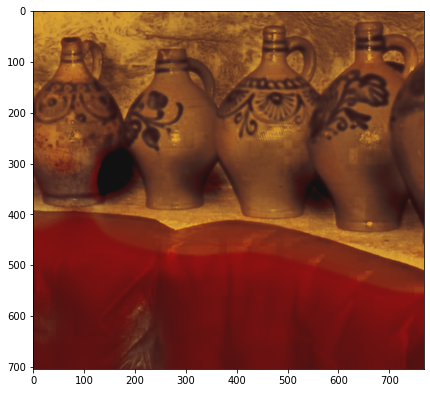

Iteration 00150    Loss 0.009663

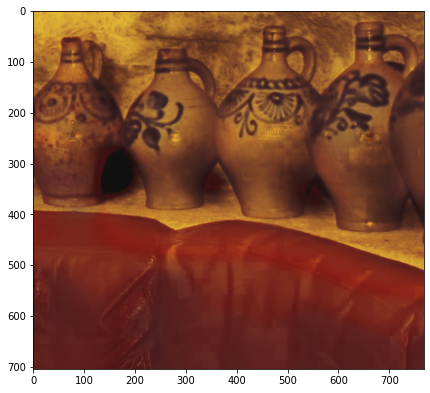

Iteration 00200    Loss 0.008412

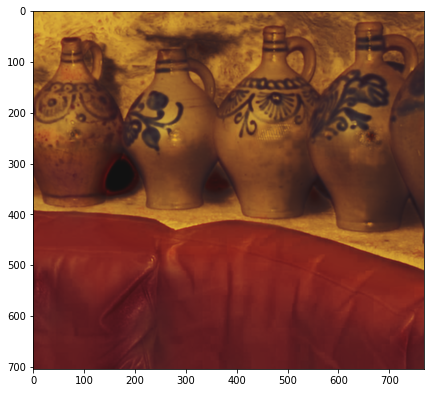

Iteration 00250    Loss 0.008124

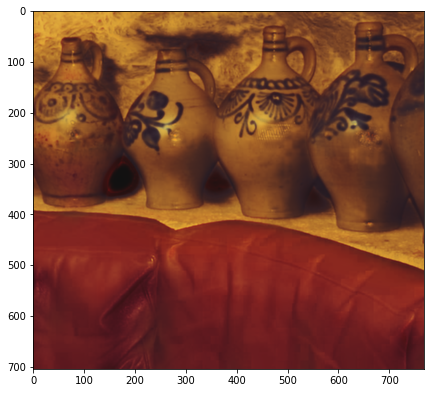

Iteration 00300    Loss 0.007812

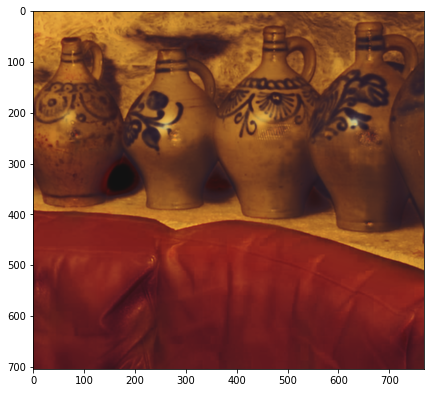

Iteration 00350    Loss 0.007518

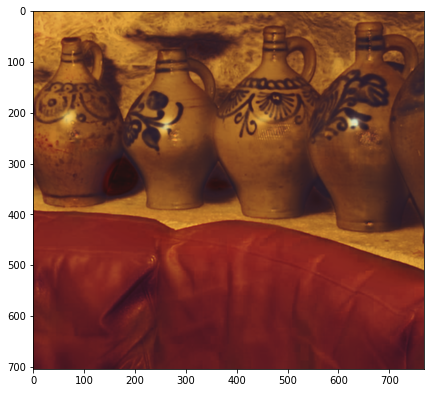

Iteration 00400    Loss 0.007433

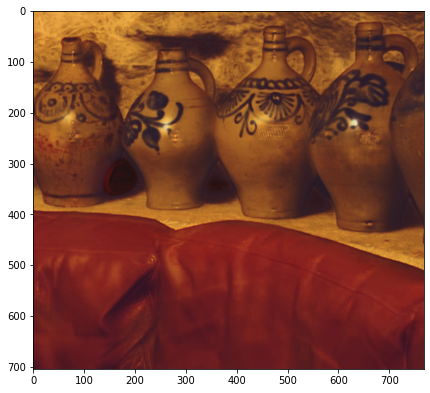

Iteration 00450    Loss 0.007325

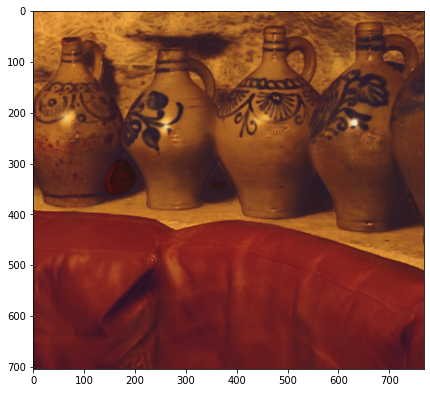

Iteration 00500    Loss 0.007186

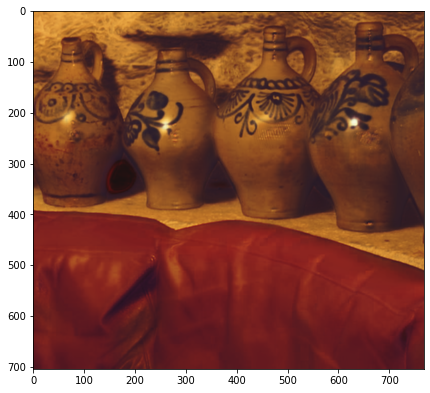

Iteration 00550    Loss 0.007086

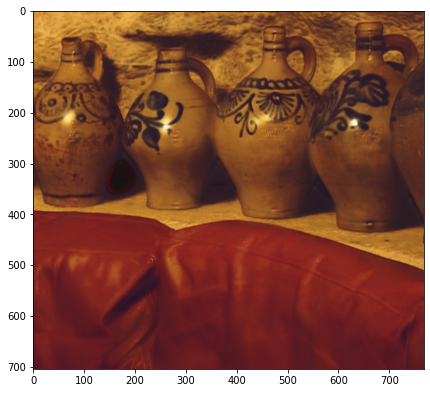

Iteration 00600    Loss 0.006944

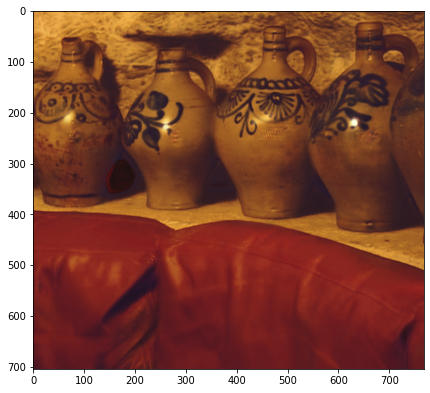

In [49]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

l=[]
acc=[]
i = 0
def closure():
    
    global i, net_input,l,acc
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
   
    total_loss = mse(out, img_noflash_var)
    l=np.append(l,total_loss.item())
    acc= np.append(acc,100-(total_loss.item()*1000))
    
    total_loss.backward()
        
    if  PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), sep='\n', end='')
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np+0.07, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


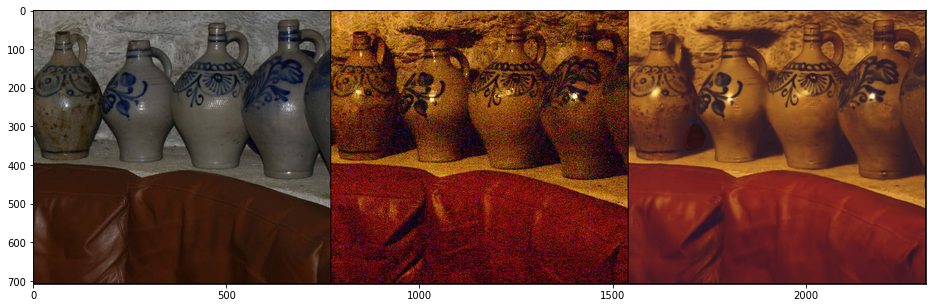

In [50]:
out_np = torch_to_np(net(net_input))
out=torch_to_np(net(net_input))+0.07
q = plot_image_grid([img_flash_np,img_noflash_np,np.clip(out, 0, 1)], factor=13,nrow=3);

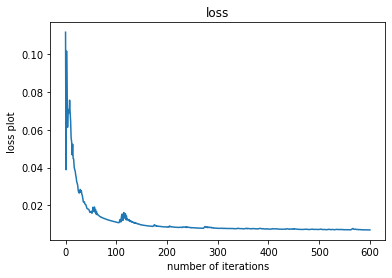

In [51]:
# plt.plot?
plt.title('loss')
plt.xlabel('number of iterations')
plt.ylabel('loss plot')
plt.plot(l)
plt.show()

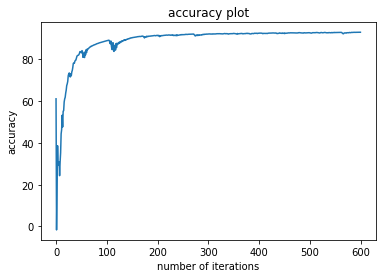

In [52]:
plt.xlabel('number of iterations')
plt.ylabel('accuracy')
acc=acc[1:]
plt.title('accuracy plot')
plt.plot(acc)
plt.show()

### **Detailed Color Enhancement**

In [53]:
!apt install caffe-cuda
!git clone -l -s https://github.com/ritusingla/colorization/ colorization
%cd colorization

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cuda is already the newest version (1.0.0-6build1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
fatal: destination path 'colorization' already exists and is not an empty directory.
/content/colorization/colorization


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import caffe
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

In [55]:
!wget -O models/colorization_release_v1.caffemodel http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel

--2020-05-31 06:15:36--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel [following]
--2020-05-31 06:15:36--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128948189 (123M)
Saving to: ‘models/colorization_release_v1.caffemodel’

models/colorization 100%[===================

In [0]:
gpu_id = 0
caffe.set_mode_gpu()
caffe.set_device(gpu_id)
net = caffe.Net('models/colorization_deploy_v1.prototxt', 'models/colorization_release_v1.caffemodel', caffe.TEST)

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape
net.blobs['Trecip'].data[...] = 6/np.log(10) # 1/T, set annealing temperature
    # (We found that we had introduced a factor of log(10). We will update the arXiv shortly.)

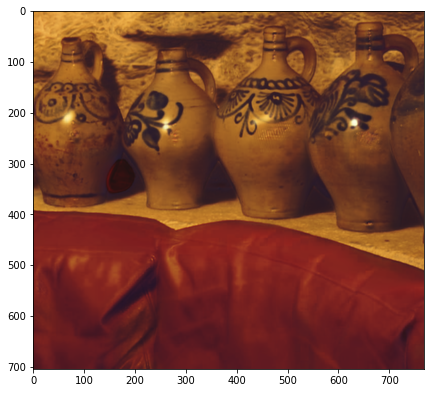

In [57]:
plot_image_grid([np.clip(out, 0, 1)], factor=figsize, nrow=1)
plt.show()


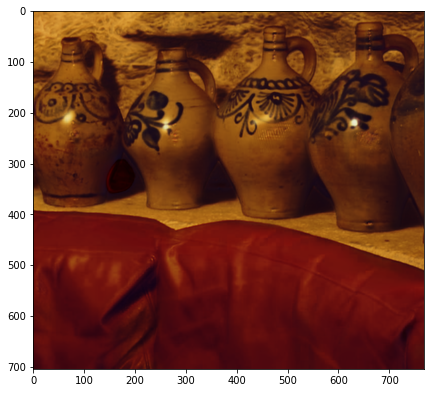

In [58]:

net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
out_HR_np = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
plt.show()


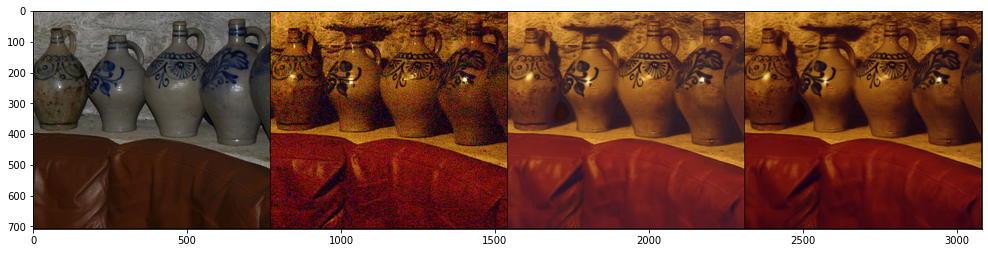

In [60]:
q = plot_image_grid([img_flash_np,img_noflash_np,np.clip(out, 0, 1),np.clip(out_np,0,1)], factor=13,nrow=4);